**Alexnet** is a convolutional neural network that was designed by Alex Krizhevsky, in collaboration with Ilya Sutskever and Geoffrey Hinton. In ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2010, this network was trained to classify 1.2 million high-resolution images into 1000 different classes. It achieved top-1 and top-5 error rates of 37.5% and 17%, which outperforms state-of-the-art methods at that time [1]. 

The design of Alexnet and LeNet are very similar, but Alexnet is much deeper with more filters per layer. It consists of eight layers: five convolutional layers (some of them are followed by max-pooling layers), two fully connected hidden layers, and one fully connected output layer. Especially, training this network is also feasible in multiple GPUs. In ILSVRC 2012, a variant of this model is trained using some technique to avoid overfititng such as data augmentation, dropout. Consequently, it won the competition with top-5 test error rate of 15.3% was achieved. 

In this project, we are going to discover the architecture of this network, as well as its implementation in Keras platform. We further applied this network for classifying dog and cat images. 

# I. Architechture
The architecture of Alexnet is described in the following figure [1]:

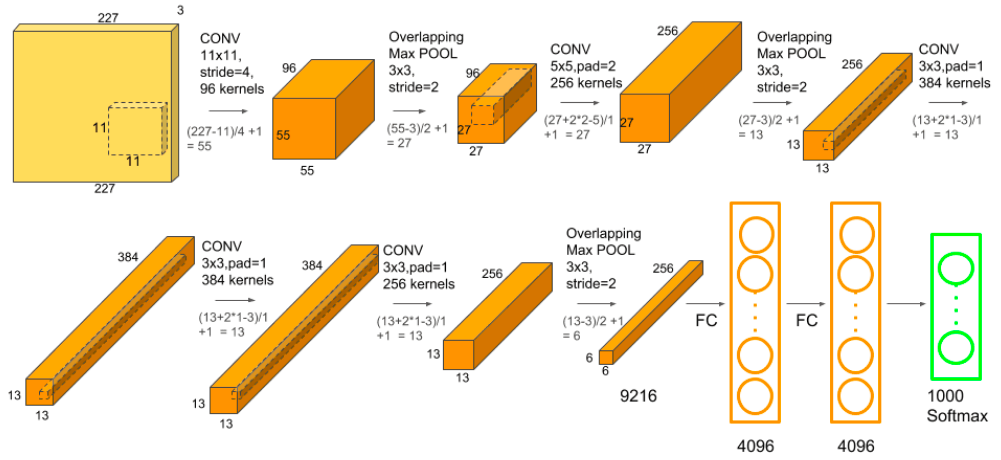

In the first layer, a convolutional window of size 11 × 11 is used. It is because of input size is large, so we need to use a large kernel to capture the object. The convolutional window shape in the next layers is reduced gradually to 5× 5 and 3 × 3, but the number of filters is increased in parallel. The two first and the last convolutional layers are followed by max-pooling layers, where a pooling window size of 3 × 3 and a stride of 2 steps are applied. Hence, the output size is halved through these layers. 

In this model, the ReLU activation function was applied [1]. You can see my previous post for more detail about this function. Besides, the authors also used some techniques to reduce overfitting phenomena, such as data augmentation and dropout. For more detail, the dropout technique was applied in the two first fully connected layers with a dropping ratio is 50%.

Implementation of Alexnet model on Keras:

## II. Application Alexnet model to dog and cat classification
The dataset is collected from Kaggle, this data consists of a training set and a test set: 
- Training set includes 4006 images of dogs and 4001 images of cats.
- Testing set includes 1013 images of dog and 1012 images of cats. 


In [1]:
import os

In [2]:
!gdown 1RxLFWqZRLbt3XYFjGve8zr-f0TYYE0iH
!mkdir car-or-truck
!unzip car-or-truck.zip -d ./car-or-truck

Streaming output truncated to the last 5000 lines.
  inflating: car-or-truck/valid/Car/05205.jpeg  
  inflating: car-or-truck/valid/Car/05206.jpeg  
  inflating: car-or-truck/valid/Car/05208.jpeg  
  inflating: car-or-truck/valid/Car/05213.jpeg  
  inflating: car-or-truck/valid/Car/05214.jpeg  
  inflating: car-or-truck/valid/Car/05217.jpeg  
  inflating: car-or-truck/valid/Car/05218.jpeg  
  inflating: car-or-truck/valid/Car/05219.jpeg  
  inflating: car-or-truck/valid/Car/05221.jpeg  
  inflating: car-or-truck/valid/Car/05222.jpeg  
  inflating: car-or-truck/valid/Car/05225.jpeg  
  inflating: car-or-truck/valid/Car/05226.jpeg  
  inflating: car-or-truck/valid/Car/05227.jpeg  
  inflating: car-or-truck/valid/Car/05228.jpeg  
  inflating: car-or-truck/valid/Car/05234.jpeg  
  inflating: car-or-truck/valid/Car/05236.jpeg  
  inflating: car-or-truck/valid/Car/05238.jpeg  
  inflating: car-or-truck/valid/Car/05239.jpeg  
  inflating: car-or-truck/valid/Car/05241.jpeg  
  inflating: car-o

### 1. Data loading and exploration

In [3]:
train_path = './car-or-truck/train/'
test_path = './car-or-truck/valid/'

In [4]:
print('The training set consists of ', len(os.listdir(train_path + 'Car/')), ' car images and ', len(os.listdir(train_path + 'Truck/')), ' truck images.' )

The training set consists of  2961  car images and  2156  truck images.


In [5]:
print('The test set consists of ', len(os.listdir(test_path + 'Car/')), ' car images and ', len(os.listdir(test_path + 'Truck/')), ' truck images.' )

The test set consists of  2922  car images and  2129  truck images.


Load images and labels 

In [6]:
import cv2
from PIL import Image
import numpy as np

In [7]:
cates = ['Car', 'Truck']
def load_images_and_labels(data_path, cates): 
  X = []
  y = []
  i = 0
  for index, cate in enumerate(cates): 
    for img_name in os.listdir(data_path + cate + '/'):
      i = i +1
      print(i)
      img = cv2.imread(data_path + cate + '/' + img_name)
      if img is not None: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = Image.fromarray(img, 'RGB')
        # resize image to 227x227 which is the required input size of the Alexnet model
        img_rs = img_array.resize((227,227))
        # convert the image to array
        img_rs = np.array(img_rs)
      
        X.append(img_rs)
        y.append(index)
  return X, y

Load the training data 

In [8]:
X_train, y_train = load_images_and_labels(train_path, cates)

Streaming output truncated to the last 5000 lines.
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
3

Load the test set

In [9]:
X_test, y_test = load_images_and_labels(test_path, cates)

Streaming output truncated to the last 5000 lines.
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
3

In [10]:
print('Training size: ', len(X_train), 'Testing size: ', len(X_test))

Training size:  5117 Testing size:  5051


Display randomly some images of the training set: 

In [11]:
import matplotlib.pyplot as plt
import random

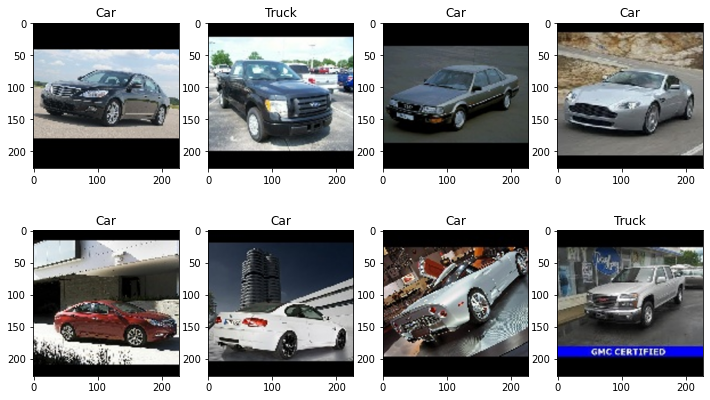

In [12]:
plt.figure(figsize = (12,7))
cate = ['Car', 'Truck']
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[y_train[ind]])

### 2. Data preprocessing

This task consists of the following steps: 
- Convert integer values into floats
- Normalization
- One-hot encoding 

In [13]:
from tensorflow.keras.utils import to_categorical

In [14]:
def preprocess_data(X, y):
  # convert X from list to array
  X = np.array(X)
  
  # convert integer values of X into floats
  X = X.astype(np.float32)

  # normalization 
  X = X/255.0
  
  # one-hot encoding the labels 
  y = to_categorical(np.array(y))
    
  return X, y

In [15]:
(X_train, y_train) = preprocess_data(X_train, y_train)

In [16]:
(X_test, y_test) = preprocess_data(X_test, y_test)

Visualize some images of the training set after preprocessing: 

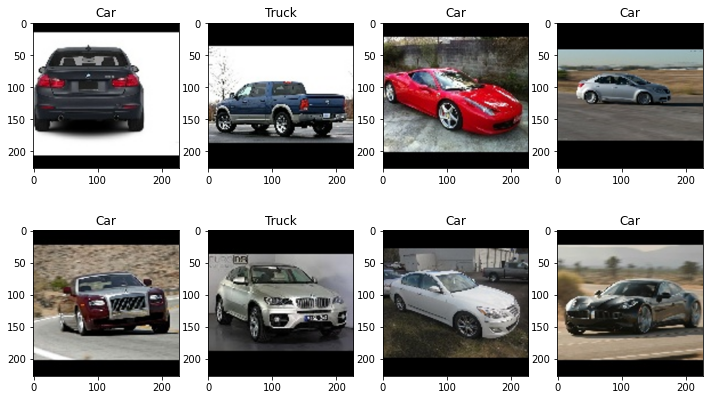

In [17]:
plt.figure(figsize = (12,7))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[np.argmax(y_train[ind])])

### 3. Define the Alexnet model
Remark that the output number in this case is two, which is corresponding to the number of classes 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# metric
from tensorflow.keras.metrics import binary_crossentropy
# optimization method (Stochastic Gradient Descent (SGD))
from tensorflow.keras.optimizers import SGD

In [19]:
def Alexnet():
  # Initialize the model
  model = Sequential(name="AlexNet")

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'softmax'))

  # compile the model with a loss funciton, a metric and and optimizqation method
  opt = SGD(lr = 0.1)
  model.compile(loss = binary_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'])

  return model

In [20]:
Alexnet_model = Alexnet()
Alexnet_model.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1327

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 4. Train the model
In this section, we apply data augementation techniques to reduce overfitfing, including rotation the image of 5 degrees, width shift range is 0.1, height shift range is 0.1 and horieontal flip. These techniques can be affected thanks to the ***ImageDataGenerator*** function from the ***keras.preprocessin.image*** module. 

Define the training function: 

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
  # Data generator
  datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)
  # iteration on the training set
  it_train = datagen.flow(X_train, y_train, batch_size = batch_size)
  # path to save checkpoint 
  path_cp = os.getcwd() + '/' + 'weights_.hdf5'
  checkpoint_ = ModelCheckpoint(path_cp, monitor = 'loss', save_best_only = True, mode = 'auto')
  steps = X_train.shape[0]//batch_size
  # Fitting the model
  history = model.fit(it_train, epochs = epochs, steps_per_epoch = steps, 
                                validation_data = (X_test, y_test), verbose = 1, 
                                callbacks = checkpoint_)
  # Evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  
  return history, acc

In [23]:
train_history, acc = train_model(Alexnet_model, X_train, y_train, X_test, y_test, epochs = 1, batch_size = 128)

158/158 [==============================] - 191s 1s/step - loss: 0.6777 - accuracy: 0.5785
57.850


Save the training history and the accuracy

In [ ]:
import pandas as pd

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
train_hist_df = pd.DataFrame(train_history.history) 

train_dict = {'train_hist': train_hist_df, 
              'acc': acc}
np.save('train_dict.npy', train_dict)         

Save the trained Alexnet_model

In [ ]:
Alexnet_model.save('Alexnet_model.h5')

In [ ]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

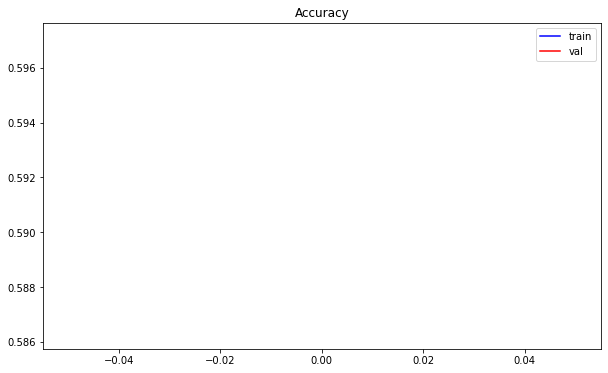

In [ ]:
plot_accuracy(train_history)

We see that the accuracies on both sets tend to increase (up to 98.85% for the training set and 90.95 % for the testing set) as the number of epochs increases. These values can still be improved with a higher number of epochs.

### 5. Prediction

In [ ]:
y_test_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  img = img.reshape(1, 227, 227, 3)
  y_p = Alexnet_model.predict(img)
  y_test_pred.append(y_p)

y_test_pred = np.asarray(y_test_pred)

Determine the confusion matrix 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

Reverse the true and the predicted labels into the original binary labels (0 and 1) to compute the confusion matrix

In [ ]:
y_test_labels = [np.argmax(vect) for vect in y_test]
y_test_pred_labels = [np.argmax(vect) for vect in y_test_pred]

In [ ]:
conf_mat = confusion_matrix(y_test_labels, y_test_pred_labels)

plt.figure(figsize = (10,8))
sns.heatmap(conf_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

This matrix describes the number of images that are correctly or incorrectly classified in each class. Based on this matrix, we see that:
- 900 dog images and 940 cat images are classified correctly in their classes.
- 112 dog images are classified into the “cat” class.
- 71 cat images are classified into the “dog” class.

Visualize some images and their predicted classes:

In [ ]:
plt.figure(figsize = (15,8))
for i in np.arange(8):
  # take randomly in indice
  ind = random.randint(0, len(X_test))
  img = X_test[ind]
  # resize the image 
  img_rs = img.reshape(1,227,227,3)
  # predict the label of img
  y_pred = Alexnet_model.predict(img_rs)
  # determine the corresponding category
  predicted_cate = cate[np.argmax(y_pred)]
  plt.subplot(240+1+i)
  plt.imshow(img)
  plt.title('predicted: ' + str(predicted_cate))

# III. Conclusion
We have discovered the architecture of the Alexnet model and its implementation on the Keras platform. This model is applied for classifying dog and cat images with a performance of 90.954 % in the testing set is achieved. However, this performance can still be improved by getting more training data, trying a higher number of epochs, changing the hyperparameters, and so on. Besides, there are also some other techniques to improve the model in each particular case, they will be introduced detailly in the next projects.

**References:**

[1] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. *Advances in neural information processing systems*, 25, 1097–1105.